# Causal transformer model using learnable embedding layer and position encodings

In [1]:
import pandas as pd
import re
import string
import nltk
import string
import emoji
import contractions
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from unidecode import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
import html


In [2]:
df = pd.read_csv("Sentiment_Data.csv",  encoding="ISO-8859-1")

In [3]:
df.head()

,Tweet,Sentiment
0,@_angelica_toy Happy Anniversary!!!....The Day...,Mild_Pos
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Mild_Pos
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Mild_Pos
3,@NChartierET Happy Anniversary!!!....The Day t...,Mild_Pos
4,@tabithapeters05 Happy Anniversary!!!....The D...,Mild_Pos


In [4]:
df.dropna(subset=["Tweet", "Sentiment"], inplace=True)

In [5]:
df.duplicated().sum()

36

In [6]:
grouped = df.groupby(['Tweet', 'Sentiment']).size().reset_index(name='count')

df = (
    grouped.sort_values(['Tweet', 'count'], ascending=[True, False])
           .drop_duplicates(subset=['Tweet'])
           .drop(columns=['count'])
           .reset_index(drop=True)
)


In [7]:
label_map = {
    "Mild_Pos": "positive", "Strong_Pos": "positive",
    "Mild_Neg": "negative", "Strong_Neg": "negative",
    "Neutral": "neutral"
}
df["Sentiment"] = df["Sentiment"].map(label_map)

In [8]:
X = df["Tweet"]
y = df["Sentiment"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['Sentiment']
)

In [9]:
regex_patterns = {
    'url': r'http[s]?://\S+',                 
    'mention': r'@\w+',                          
    'hashtag': r'#\w+',                         
    'html': r'<[^>]+>',                         
    'retweet': r'\bRT\b',                       
    'repeated_chars': r'(.)\1{2,}',              
    'punctuation': r'[^\w\s!?]',                
    'numbers': r'\b\d+\b',                       
    'whitespace': r'\s+'                         
}

In [10]:
slang_dict = {
    'lol': 'laugh out loud', 'omg': 'oh my god', 'wtf': 'what the fuck',
    'btw': 'by the way', 'tbh': 'to be honest', 'idk': 'i dont know',
    'fyi': 'for your information', 'freedomconvoy': 'freedom_convoy',
    'ainat': 'am not', 'vccinted': 'vaccinated', 'uoftlaw': 'university_of_toronto_law',
    'kukluxkonvoy': 'ku_klux_klan_convoy', 'cdnpoli': 'canadian_politics',
    'btwn': 'between',
    'ctully': 'actually',
    'toa': 'to a',
    'prticipnts': 'participants',
    'lwmkers': 'lawmakers',
    'dod': 'department of defense',  
    'deg': 'degree' ,
    'ea': 'emergencies_act',            
    'ctul': 'actual',
    
}


In [11]:
abbreviation_dict = {
    'usa': 'united states of america', 'nyc': 'new york city',
    'govt': 'government', 'dr': 'doctor', 'hr': 'hour',
    'cnad': 'canada', 'ottw': 'ottawa',
    'cdnpoli': 'canadian_politics',
    'dod': 'department_of_defense'
}


In [12]:
def expand_chat_words(text):
    """Handles contractions and slang"""
    text = re.sub(r'\b(u|ur|r)\b', lambda x: {'u': 'you', 'ur': 'your', 'r': 'are'}[x.group()], text)
    text = contractions.fix(text)  
    return text

In [13]:
def handle_negations(text):
    """Merges negations (e.g., "not good" → "not_good")"""
    negations = ['not', 'never', 'no', 'without']
    for word in negations:
        text = re.sub(rf'\b{word}\b\s+(\w+)', f'{word}_\\1', text)
    return text

In [14]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))  
def clean_text(text):
    """Full preprocessing pipeline optimized for transformers"""
    if pd.isna(text):
        return "", []
    
    text = str(text).lower()
    text = unidecode(text)  
    text = html.unescape(text)        
    
    for pattern in regex_patterns.values():
        text = re.sub(pattern, ' ', text)
   
    text = expand_chat_words(text)
    words = []
    for word in text.split():
        word = slang_dict.get(word, word)          
        word = abbreviation_dict.get(word, word)   
        words.append(word)
    text = ' '.join(words)
  
    text = handle_negations(text)
 
    tokens = [lemmatizer.lemmatize(w) for w in word_tokenize(text) 
              if w not in stop_words.union({'rt'}) and len(w) > 2]
    
    return ' '.join(tokens), tokens

In [16]:
X_train_clean = X_train.apply(lambda x: clean_text(x)[0])
X_test_clean = X_test.apply(lambda x: clean_text(x)[0])

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [26]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_clean)

In [27]:
X_train_seq = tokenizer.texts_to_sequences(X_train_clean)
X_test_seq = tokenizer.texts_to_sequences(X_test_clean)

In [28]:
max_len = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [30]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [31]:
y_encoder = LabelEncoder()  
y_train_int = y_encoder.fit_transform(y_train) 
y_test_int = y_encoder.transform(y_test) 
y_train = to_categorical(y_train_int)
y_test = to_categorical(y_test_int)

# Model

In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, Dropout, Dense, Embedding
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from time import time

# 1. Positional Encoding Layer
class PositionalEncoding(Layer):
    def __init__(self, max_len, d_model):
        super(PositionalEncoding, self).__init__()
        self.max_len = max_len
        self.d_model = d_model
        
        # Create positional encodings
        position = np.arange(max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        
        pe = np.zeros((max_len, d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.pe = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)
        
    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        return inputs + self.pe[:, :seq_len, :]

In [36]:
# 2. Transformer Block with Causal Masking
class TransformerBlock(Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def call(self, inputs, training):
        # Causal mask
        seq_len = tf.shape(inputs)[1]
        causal_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        
        # Multi-head attention
        attn_output = self.mha(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask
        )
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        # Feed forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [37]:
def build_causal_transformer(vocab_size, max_len, d_model=32, num_heads=2, ff_dim=32, rate=0.1):
    inputs = tf.keras.Input(shape=(max_len,))
    
    # Learnable Embeddings
    x = layers.Embedding(vocab_size, d_model, mask_zero=True)(inputs)
    
    # Positional Encoding (assuming you have this class defined)
    x = PositionalEncoding(max_len, d_model)(x)
    x = layers.Dropout(rate)(x)
    
    # Transformer Blocks
    x = TransformerBlock(d_model, num_heads, ff_dim, rate)(x, training=True)
    x = TransformerBlock(d_model, num_heads,ff_dim, rate)(x, training=True)
    
    # Pooling and Output
    x = layers.GlobalAveragePooling1D()(x)  # Fixed typo: "GlObal" → "Global"
    x = layers.Dropout(rate)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(rate)(x)
    outputs = layers.Dense(3, activation='softmax', kernel_regularizer=l2(0.01))(x)
    
    return Model(inputs=inputs, outputs=outputs)

In [38]:
# 6. Model Training and Evaluation
print("Building Causal Transformer Model...")
transformer_model = build_causal_transformer(
    vocab_size=len(tokenizer.word_index)+1,
    max_len=max_len,
    num_heads=2,
    ff_dim=32
)

transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Building Causal Transformer Model...


In [83]:
# Training
print("\nTraining model...")
start_time = time()
history = transformer_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_test_pad, y_test),
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)],
    verbose=1
)
train_time = time() - start_time


Training model...
Epoch 1/10
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 1228s 419ms/step - accuracy: 0.6821 - loss: 0.8378 - val_accuracy: 0.8270 - val_loss: 0.5068
Epoch 2/10
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 1018s 361ms/step - accuracy: 0.8235 - loss: 0.5052 - val_accuracy: 0.8479 - val_loss: 0.4304
Epoch 3/10
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 885s 314ms/step - accuracy: 0.8438 - loss: 0.4459 - val_accuracy: 0.8542 - val_loss: 0.4078
Epoch 4/10
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 930s 330ms/step - accuracy: 0.8556 - loss: 0.4152 - val_accuracy: 0.8659 - val_loss: 0.3854
Epoch 5/10
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 1049s 353ms/step - accuracy: 0.8651 - loss: 0.3915 - val_accuracy: 0.8711 - val_loss: 0.3765
Epoch 6/10
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 952s 338ms/step - accuracy: 0.8698 - loss: 0.3759 - val_accuracy: 0.8724 - val_loss: 0.3693
Epoch 7/10
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 871s 309ms/step - accuracy: 0.8747 - loss: 0.3642 - val_accuracy: 0.8746 - val_loss: 0.3669
Epoch 8/10
2821/2821 ━━━━━━━━━━━━━━━━━━━

# Evaluation

In [98]:
# Predict
train_pred_prob = transformer_model.predict(X_train_pad)
test_pred_prob = transformer_model.predict(X_test_pad)

train_pred = np.argmax(train_pred_prob, axis=1)
test_pred = np.argmax(test_pred_prob, axis=1)

y_train_true = np.argmax(y_train, axis=1)
y_test_true = np.argmax(y_test, axis=1)

11282/11282 ━━━━━━━━━━━━━━━━━━━━ 395s 35ms/step
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 96s 34ms/step


In [99]:
# 4. Accuracy
train_acc = accuracy_score(y_train_true, train_pred)
test_acc = accuracy_score(y_test_true, test_pred)

print(f"\nTrain Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Train Accuracy: 0.8996
Test Accuracy: 0.8793


In [100]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, classification_report, accuracy_score

In [101]:
# Define class names
class_names = y_encoder.classes_

In [102]:
# Metrics
train_acc = accuracy_score(y_train_true, train_pred)
test_acc = accuracy_score(y_test_true, test_pred)

train_auc = roc_auc_score(y_train, train_pred_prob, multi_class='ovr')
test_auc = roc_auc_score(y_test, test_pred_prob, multi_class='ovr')

train_report = classification_report(y_train_true, train_pred, target_names=class_names, output_dict=True)
test_report = classification_report(y_test_true, test_pred, target_names=class_names, output_dict=True)

train_f1_positive = train_report['positive']['f1-score']
train_f1_neutral = train_report['neutral']['f1-score']
train_f1_negative = train_report['negative']['f1-score']

test_f1_positive = test_report['positive']['f1-score']
test_f1_neutral = test_report['neutral']['f1-score']
test_f1_negative = test_report['negative']['f1-score']

In [103]:
print(f"Train F1 Score (Positive): {train_f1_positive:.4f}")
print(f"Train F1 Score (Negative): {train_f1_negative:.4f}")
print(f"Train F1 Score (Neutral): {train_f1_neutral:.4f}")
print(f"Test F1 Score (Positive): {test_f1_positive:.4f}")
print(f"Test F1 Score (Negative): {test_f1_negative:.4f}")
print(f"Test F1 Score (Neutral): {test_f1_neutral:.4f}")

Train F1 Score (Positive): 0.9437
Train F1 Score (Negative): 0.8329
Train F1 Score (Neutral): 0.7745
Test F1 Score (Positive): 0.9333
Test F1 Score (Negative): 0.7964
Test F1 Score (Neutral): 0.7264


In [104]:
# Confusion Matrices
train_cm = confusion_matrix(y_train_true, train_pred)
test_cm = confusion_matrix(y_test_true, test_pred)

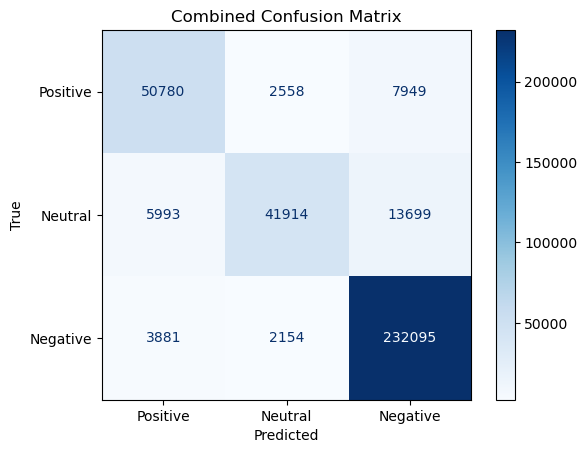

In [105]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=['Positive', 'Neutral', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Combined Confusion Matrix')
plt.show()

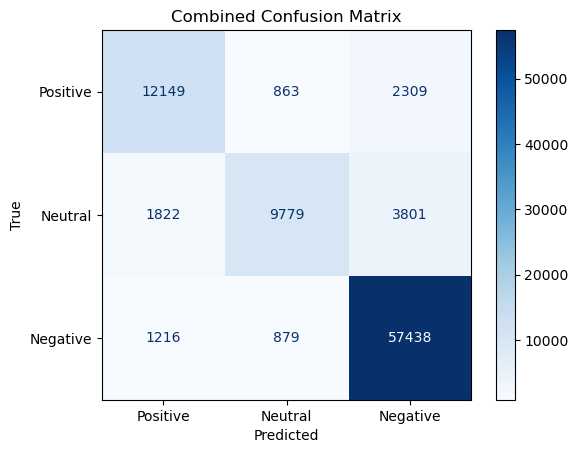

In [106]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['Positive', 'Neutral', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Combined Confusion Matrix')
plt.show()

In [107]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score,ConfusionMatrixDisplay

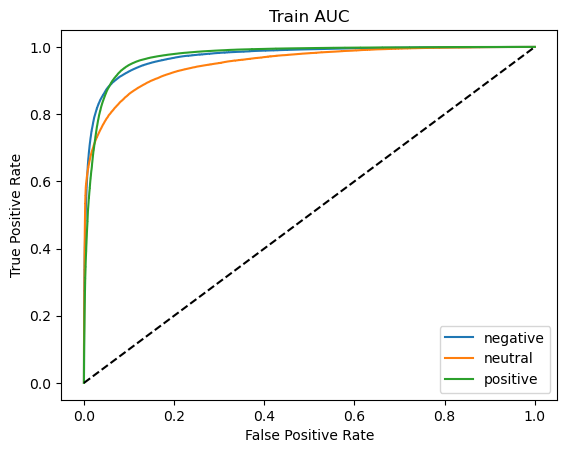

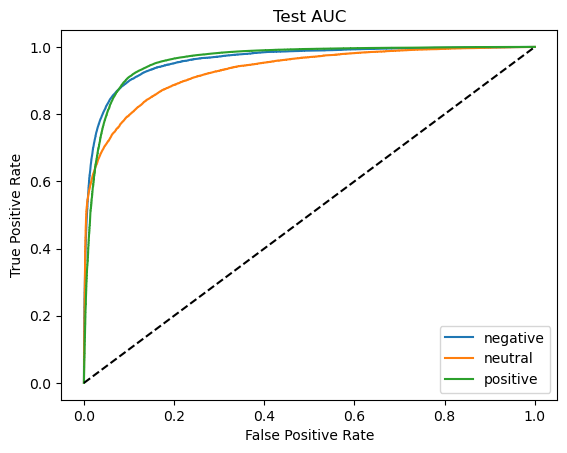

In [108]:
# AUC Plots

def plot_auc(y_true, y_score, title):
    for i in range(3):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f"{class_names[i]}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

plot_auc(y_train, train_pred_prob, "Train AUC")
plot_auc(y_test, test_pred_prob, "Test AUC")

In [109]:
# Summary
print("\nMODEL TRAINING SUMMARY")
print("="*150)
print(f"Train Time: {train_time:.2f} seconds")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


MODEL TRAINING SUMMARY
Train Time: 9638.11 seconds
Train Accuracy: 0.8996
Test Accuracy: 0.8793
Train AUC: 0.9651
Test AUC: 0.9505
